# Lab 2: Cats vs Dogs

**Deadline**: January 30, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**Marking TA**: Tinglin (Francis) Duan

This lab is partially based on an assignment developed by Prof. Jonathan Rose and Harris Chan.

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1e7CSB_O9nPg8z0ggmUvXJesGQEDPeLZU#scrollTo=pjI2Zw9jqIFg

In [0]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [0]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Returns the indices for datapoints in the dataset that
    belongs to the desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_train_indices = get_relevant_indices(
            trainset,
            classes,
            target_classes)
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_train_indices)
    split = int(len(relevant_train_indices) * 0.8)
    relevant_train_indices, relevant_val_indices = relevant_train_indices[:split], relevant_train_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [3]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

0it [00:00, ?it/s]

170500096it [00:06, 26587152.41it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

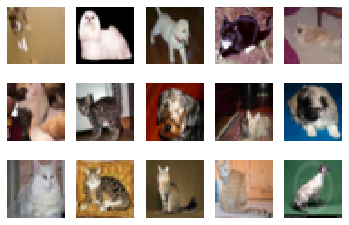

In [58]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [9]:
print("number of training examples: ", len(train_loader))
print("number of validation examples: ", len(val_loader))
print("number of test examples: ", len(test_loader))

number of training examples:  8000
number of validation examples:  2000
number of test examples:  2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

In [0]:
# we need a validation set because it helps us to find 
# whether the training model overfits and to chose the hyperparameters 
# as the validation set can be used to assess the performance of 
# our training model for various combinations of hyperparameters

# If we judge the performance of our models using training set's 
# loss/error instead of validation set's loss/error, 
# the model will overfit the training set which means that 
# our model will work well for training set but not for other sets

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [0]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [0]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [0]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [24]:
cnt_small = 0
for param in small_net.parameters():
    print(param.shape)
    tmp_small = 1
    for i in range(len(list(param.shape))):
      tmp_small *= param.shape[i]
    cnt_small += tmp_small

cnt_large = 0
for param in large_net.parameters():
    print(param.shape)
    tmp_large = 1
    for i in range(len(list(param.shape))):
      tmp_large *= param.shape[i]
    cnt_large += tmp_large

print("number of parameters in small_net: ", cnt_small)
print("number of parameters in large_net: ", cnt_large)
print("number of parameters in total: ", cnt_large + cnt_small)

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])
torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])
number of parameters in small_net:  386
number of parameters in large_net:  9705
number of parameters in total:  10091


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [0]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
        # part c
        # print(model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)
    # part c
    # print("{}_train_err.csv".format(model_path))
    # print("{}_train_loss.csv".format(model_path))
    # print("{}_val_err.csv".format(model_path))
    # print("{}_val_loss.csv".format(model_path))

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

In [0]:
# default:
# batch_size: 64
# learning_rate: 0.01
# num_epochs: 30

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [0]:
train_net(small_net, 64, 0.01, 5)

# the following files contains the current model(checkpoint) of each epoch:
# model_small_bs64_lr0.01_epoch0
# model_small_bs64_lr0.01_epoch1
# model_small_bs64_lr0.01_epoch2
# model_small_bs64_lr0.01_epoch3
# model_small_bs64_lr0.01_epoch4

# the following files contains the train/test loss/err:
# model_small_bs64_lr0.01_epoch4_train_err.csv
# model_small_bs64_lr0.01_epoch4_train_loss.csv
# model_small_bs64_lr0.01_epoch4_val_err.csv
# model_small_bs64_lr0.01_epoch4_val_loss.csv

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.315625, Train loss: 0.5942500612735748 |Validation err: 0.3285, Validation loss: 0.6126255448907614
model_small_bs64_lr0.01_epoch0
Epoch 2: Train err: 0.311125, Train loss: 0.5891596248149872 |Validation err: 0.33, Validation loss: 0.6191111374646425
model_small_bs64_lr0.01_epoch1
Epoch 3: Train err: 0.311875, Train loss: 0.5860089321136475 |Validation err: 0.322, Validation loss: 0.6035325787961483
model_small_bs64_lr0.01_epoch2
Epoch 4: Train err: 0.306, Train loss: 0.5819482979774475 |Validation err: 0.321, Validation loss: 0.6072137514129281
model_small_bs64_lr0.01_epoch3
Epoch 5: Train err: 0.303, Train loss: 0.5775879309177399 |Validation err: 0.312, Validation loss: 0.6021736115217209
model_small_bs64_lr0.01_epoch4
Finished Training
Total time elapsed: 17.51 seconds
model_small_bs64_lr0.01_epoch4_train_err.csv
model_small_bs64_lr0.01_epoch4_train_loss.csv
model_small_bs64_lr0.01_epo

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [26]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [29]:
# start a new train
small_net = SmallNet()
large_net = LargeNet()
train_net(small_net)
train_net(large_net)

# the total time elapsed for small_net: 106.76 seconds
# the total time elapsed for large_net: 120.72 seconds
# large_net takes longer time than small_net 
# because their structures and trainable parameters are different
# the large_net has two convolution layers 
# while small_net only has one convolution layer
# it takes longer time for large_net to train 

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.439375, Train loss: 0.6837765421867371 |Validation err: 0.3915, Validation loss: 0.6662272289395332
Epoch 2: Train err: 0.380875, Train loss: 0.6527453322410584 |Validation err: 0.3935, Validation loss: 0.6626366525888443
Epoch 3: Train err: 0.342125, Train loss: 0.625328052520752 |Validation err: 0.3335, Validation loss: 0.6186922714114189
Epoch 4: Train err: 0.323875, Train loss: 0.6055600070953369 |Validation err: 0.339, Validation loss: 0.6171749532222748
Epoch 5: Train err: 0.314625, Train loss: 0.5930321733951569 |Validation err: 0.3215, Validation loss: 0.6096237320452929
Epoch 6: Train err: 0.29975, Train loss: 0.581014221906662 |Validation err: 0.3265, Validation loss: 0.6049923654645681
Epoch 7: Train err: 0.2975, Train loss: 0.5773153674602508 |Validation err: 0.3305, Validation loss: 0.600175685249269
Epoch 8: Train err: 0.295125, Train loss: 0.5693165059089661 |Validation err:

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

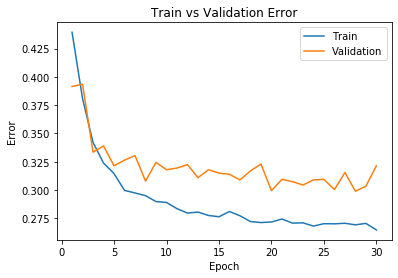

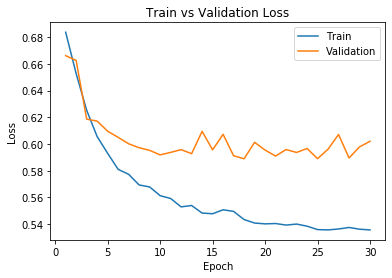

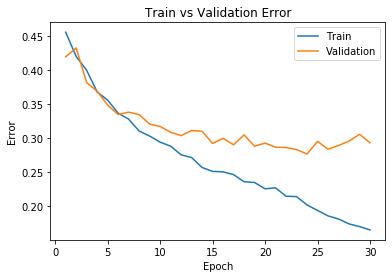

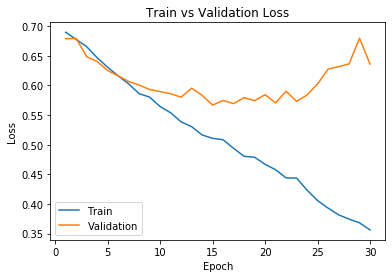

In [30]:
#model_path = get_model_name("small", batch_size=??, learning_rate=??, epoch=29)
model_path_small = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_small)
model_path_large = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

In [0]:
# errors measure the deviation of observed value to predicted value
# losses quantify the errors' negavtive consequences

# notice:
# the train error and loss decrease as epoch number increases 
# for both small_net and larget_net
# while the decrease on large_net is more linear than small_net
# and at the end, the train error and loss of large_net is smaller
# than the train error and loss of small_net

# the validation error decreases as epoch number increases 
# for both small_net and large_net
# while the decrease on large_net is smoothier than small_net
# the validation loss decreases as epoch number increases for small_net
# the validation loss decreases first 
# and then starts increasing since 15 epochs for large_net


# ==============================================================================

# occurence of overfitting 
# large_net: starts from 15 epochs, overfitting occurs 
# as validation loss starts increasing, 
# while train loss decreases;
# it starts to seize some subtle patterns that are included in 
# training set only, and leads to a overfit

# ==============================================================================

# occurence of underfitting 
# small_net: starts from 0 to around 10 epochs, underfitting occurs,
# as both validation and train errors decrease
# large_net: starts from 0 to 15 epochs, underfitting occurs,
# as both validation and train errors decrease


## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360023498535 |Validation err: 0.467, Validation loss: 0.6924686655402184
Epoch 2: Train err: 0.448625, Train loss: 0.6922589688301086 |Validation err: 0.4305, Validation loss: 0.6916493382304907
Epoch 3: Train err: 0.43575, Train loss: 0.6916067261695862 |Validation err: 0.4285, Validation loss: 0.6908544152975082
Epoch 4: Train err: 0.43, Train loss: 0.6908614072799683 |Validation err: 0.4245, Validation loss: 0.6896600145846605
Epoch 5: Train err: 0.434375, Train loss: 0.689919647693634 |Validation err: 0.4195, Validation loss: 0.6886944100260735
Epoch 6: Train err: 0.435875, Train loss: 0.6887412457466126 |Validation err: 0.4195, Validation loss: 0.6867826543748379
Epoch 7: Train err: 0.43675, Train loss: 0.6873777341842652 |Validation err: 0.418, Validation loss: 0.6851988434791565
Epoch 8: Train err: 0.437375, Train loss: 0.6859265742301941 |Validation err: 0.

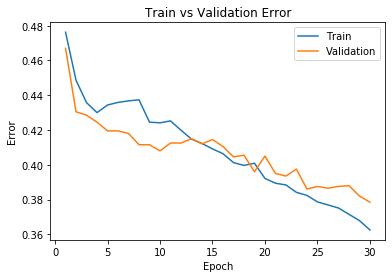

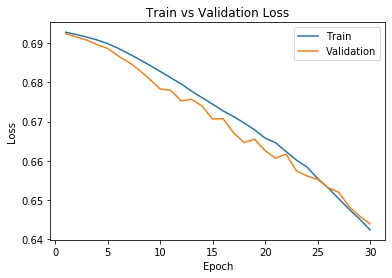

In [0]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, batch_size=64, learning_rate=0.001, num_epochs=30)
model_path_large = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path_large)

# time difference is very small/the time does not change much
# lowering the learning rate causes the curves becomer smoothier,
# and values of error and loss of validation and train becomes closer

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.426875, Train loss: 0.6742900676727295 |Validation err: 0.3695, Validation loss: 0.6364889536052942
Epoch 2: Train err: 0.361625, Train loss: 0.6373908457756042 |Validation err: 0.3655, Validation loss: 0.6439082939177752
Epoch 3: Train err: 0.371625, Train loss: 0.6370397086143493 |Validation err: 0.3515, Validation loss: 0.6133540160953999
Epoch 4: Train err: 0.348, Train loss: 0.6141975626945496 |Validation err: 0.3365, Validation loss: 0.6044933125376701
Epoch 5: Train err: 0.333875, Train loss: 0.6029216282367706 |Validation err: 0.3245, Validation loss: 0.5935317613184452
Epoch 6: Train err: 0.3175, Train loss: 0.5871682240962982 |Validation err: 0.324, Validation loss: 0.5884642750024796
Epoch 7: Train err: 0.308, Train loss: 0.5718630583286285 |Validation err: 0.3095, Validation loss: 0.5934673277661204
Epoch 8: Train err: 0.306625, Train loss: 0.5659790558815002 |Validation err: 0

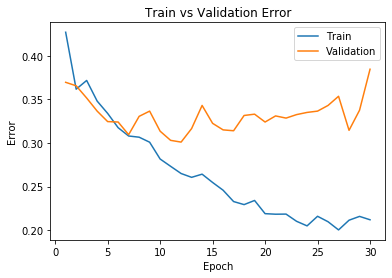

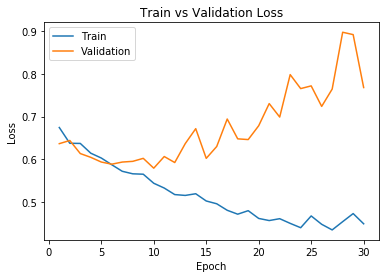

In [0]:
large_net = LargeNet()
train_net(large_net, batch_size=64, learning_rate=0.1, num_epochs=30)
model_path_large = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_path_large)

# the time difference is very small/the time does not change much
# increasing the learning rate causes it to start to overfit faster
# from 15 epochs to around 5 epochs

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379403591156 |Validation err: 0.478, Validation loss: 0.6926823854446411
Epoch 2: Train err: 0.457625, Train loss: 0.6924103908240795 |Validation err: 0.434, Validation loss: 0.6917425096035004
Epoch 3: Train err: 0.437, Train loss: 0.6916500441730022 |Validation err: 0.4265, Validation loss: 0.6909130066633224
Epoch 4: Train err: 0.433625, Train loss: 0.6908450052142143 |Validation err: 0.424, Validation loss: 0.6897870898246765
Epoch 5: Train err: 0.434, Train loss: 0.6896936446428299 |Validation err: 0.424, Validation loss: 0.6881358623504639
Epoch 6: Train err: 0.43825, Train loss: 0.6883534081280231 |Validation err: 0.428, Validation loss: 0.68601293861866
Epoch 7: Train err: 0.439375, Train loss: 0.6866869702935219 |Validation err: 0.426, Validation loss: 0.6836968064308167
Epoch 8: Train err: 0.435375, Train loss: 0.6849769502878189 |Validation err: 0.412, V

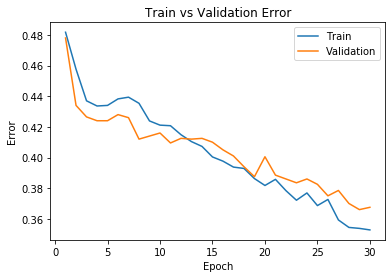

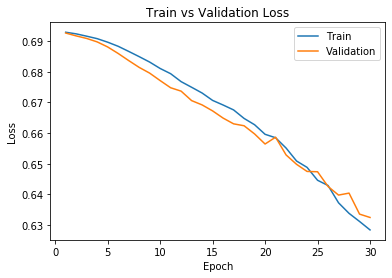

In [31]:
large_net = LargeNet()
train_net(large_net, batch_size=512, learning_rate=0.01, num_epochs=30)
model_path_large = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large)

# it takes shorter time to train 
# increasing the batch size causes the curves becomer smoothier,
# and values of error and loss of validation and train becomes closer;
# the valdiation data set and training data set matches better

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774821187257767 |Validation err: 0.378, Validation loss: 0.651921395778656
Epoch 2: Train err: 0.36875, Train loss: 0.6395755406022072 |Validation err: 0.3595, Validation loss: 0.6264406447410583
Epoch 3: Train err: 0.33875, Train loss: 0.6120929001569748 |Validation err: 0.3475, Validation loss: 0.6289729187488556
Epoch 4: Train err: 0.314375, Train loss: 0.5869516692757607 |Validation err: 0.3545, Validation loss: 0.6142054274082184
Epoch 5: Train err: 0.3115, Train loss: 0.5694829801917076 |Validation err: 0.312, Validation loss: 0.5763112711906433
Epoch 6: Train err: 0.281125, Train loss: 0.5458917077481746 |Validation err: 0.2985, Validation loss: 0.5741617560386658
Epoch 7: Train err: 0.269875, Train loss: 0.5297637034058571 |Validation err: 0.309, Validation loss: 0.6013907868862152
Epoch 8: Train err: 0.257375, Train loss: 0.5129605046510697 |Validation err: 0

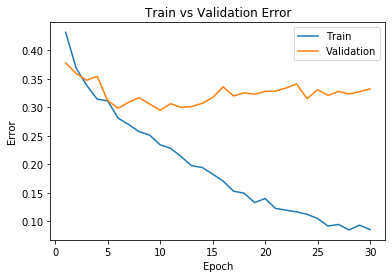

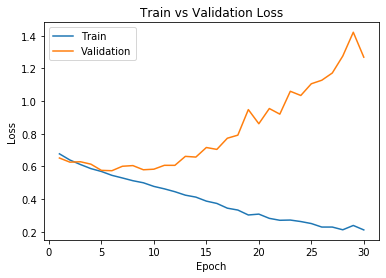

In [32]:
large_net = LargeNet()
train_net(large_net, batch_size=16, learning_rate=0.01, num_epochs=30)
model_path_large = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large)


# it takes longer time to train/the training time increases 
# decreasing the batch size causes it to start to overfit faster
# from 15 epochs to around 5 epochs

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

In [0]:
# large_net:
# batch_size: 64->128
# learning_rate: 0.01->0.006
# num_epochs: 30

# choose large_net because it has a better performance with a higher accuracy
# increase batch_size to reduce gradient noise/make it trains a less noisy
# decrease learning_rate to make the overfitting occur later, and
# also reduce the noise 
# to summarize, increase batch_size and decrease learning_rate both lead to a better performance

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.463, Train loss: 0.6924554043345981 |Validation err: 0.4305, Validation loss: 0.6912975981831551
Epoch 2: Train err: 0.451375, Train loss: 0.6905202449314178 |Validation err: 0.4245, Validation loss: 0.6877098679542542
Epoch 3: Train err: 0.43125, Train loss: 0.6871193741995191 |Validation err: 0.413, Validation loss: 0.6823645159602165
Epoch 4: Train err: 0.42675, Train loss: 0.6826523703242106 |Validation err: 0.4105, Validation loss: 0.6763048432767391
Epoch 5: Train err: 0.417, Train loss: 0.6782648412008134 |Validation err: 0.4125, Validation loss: 0.6726065464317799
Epoch 6: Train err: 0.409, Train loss: 0.6733150368645078 |Validation err: 0.4045, Validation loss: 0.6701047830283642
Epoch 7: Train err: 0.397125, Train loss: 0.6684827303129529 |Validation err: 0.393, Validation loss: 0.6641740500926971
Epoch 8: Train err: 0.392, Train loss: 0.6637214034322708 |Validation err: 0.3915, 

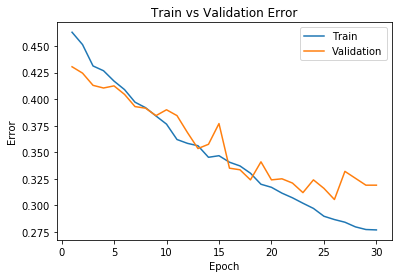

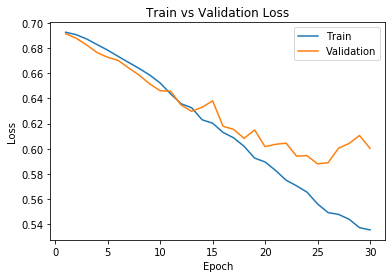

In [33]:
large_net = LargeNet()
train_net(large_net, batch_size=128, learning_rate=0.006, num_epochs=30)
model_path_large = get_model_name("large", batch_size=128, learning_rate=0.006, epoch=29)
plot_training_curve(model_path_large)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

In [0]:
# large_net:
# batch_size: 64->128->256
# learning_rate: 0.01->0.006->0.004
# num_epochs: 30

# compared to (a), keep increasing the batch_size to reduce the noise,
# and keep decreasing the learning_rate to make the overfitting occur later, and
# also reduce the noise 

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.49775, Train loss: 0.695826081559062 |Validation err: 0.509, Validation loss: 0.6957717761397362
Epoch 2: Train err: 0.497, Train loss: 0.6934274528175592 |Validation err: 0.5005, Validation loss: 0.6928286775946617
Epoch 3: Train err: 0.484, Train loss: 0.6921373680233955 |Validation err: 0.4695, Validation loss: 0.6911294981837273
Epoch 4: Train err: 0.469125, Train loss: 0.6910459604114294 |Validation err: 0.4395, Validation loss: 0.6893525794148445
Epoch 5: Train err: 0.459625, Train loss: 0.6899668239057064 |Validation err: 0.4375, Validation loss: 0.687581866979599
Epoch 6: Train err: 0.455, Train loss: 0.6892122123390436 |Validation err: 0.434, Validation loss: 0.6859336346387863
Epoch 7: Train err: 0.453, Train loss: 0.6880959905683994 |Validation err: 0.4305, Validation loss: 0.6845116093754768
Epoch 8: Train err: 0.4465, Train loss: 0.6871634647250175 |Validation err: 0.4345, Val

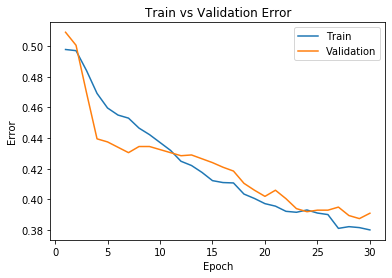

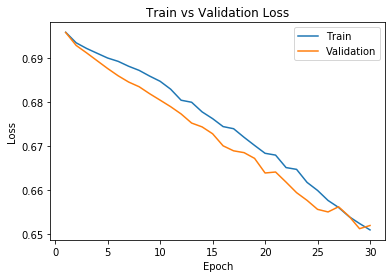

In [46]:
large_net = LargeNet()
train_net(large_net, batch_size=256, learning_rate=0.004, num_epochs=30)
model_path_large = get_model_name("large", batch_size=256, learning_rate=0.004, epoch=29)
plot_training_curve(model_path_large)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [0]:
# net = SmallNet()
# model_path = get_model_name(net.name, batch_size=64, learning_rate=0.01, epoch=10)
# state = torch.load(model_path)
# net.load_state_dict(state)

In [44]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=128, learning_rate=0.006, epoch=27)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

In [0]:
# the model I choose using the following data:
# large_net, batch_size=128, learning_rate=0.006, epoch=27;
# this model has a lowest error at 0.3055 over other combinations of hyperparameters,
# and it starts to overfit since around 27 epochs

# choose large_net because it performs better with a higher accuracy
# increase batch_size to reduce gradient noise/make it trains a less noisy
# decrease learning_rate to make the overfitting occur later, and
# also reduce the noise 

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [45]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=64)
criterion = nn.BCEWithLogitsLoss()
terror, tloss = evaluate(net, test_loader, criterion)
print(("Test Error: {}, Test Loss: {}").format(
                   terror,
                   tloss))


Files already downloaded and verified
Files already downloaded and verified
Test Error: 0.3095, Test Loss: 0.5744397789239883


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [0]:
# test error: 0.3095
# validation error: 0.3055
# we expect the test error to be higher because I choose the model
# that has the best performance on validation set and so it tends to overfit 
# the validation set
# as a result, the test error should be higher than the validation error

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

In [0]:
# we use the test data at very end because it is a completely new
# data set, and we use the final model(after trained by training set,
# and choose the hyperparameter based on validation set) on it 
# as we want to ensure that our model works well for general cases;
# the main purpose of this phase is to see how the model performs 
# on dealing with real world data that has not been seen.
# once we use the test data, we cannot tune the model 
# otherwise we will overfit the test data.

# we keep the size of test data as small as possible because we
# cannot resue it, because the reuse will cause overfit on test data set.
# if we need to modify our model, then we need a new test data set

### Part (f) - 5pt

Train a 2-layer ANN similar to what was used in Lab 1 to classific cats and dogs. Try out different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data. How does the ANN model compare to your CNN model?

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43, Train loss: 0.6732192796374125 |Validation err: 0.4065, Validation loss: 0.6598102189600468
Epoch 2: Train err: 0.3845, Train loss: 0.6485390067100525 |Validation err: 0.395, Validation loss: 0.6530866213142872
Epoch 3: Train err: 0.365875, Train loss: 0.6368026203579373 |Validation err: 0.39, Validation loss: 0.648547925055027
Epoch 4: Train err: 0.356, Train loss: 0.6280954044962687 |Validation err: 0.394, Validation loss: 0.6547794342041016
Epoch 5: Train err: 0.34575, Train loss: 0.6223525490079608 |Validation err: 0.388, Validation loss: 0.6429815255105495
Epoch 6: Train err: 0.3315, Train loss: 0.611434847589523 |Validation err: 0.3815, Validation loss: 0.6483627073466778
Epoch 7: Train err: 0.320625, Train loss: 0.603635067031497 |Validation err: 0.3805, Validation loss: 0.6458082422614098
Epoch 8: Train err: 0.31175, Train loss: 0.5937281487480043 |Validation err: 0.3675, Valid

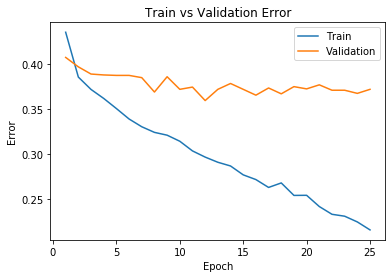

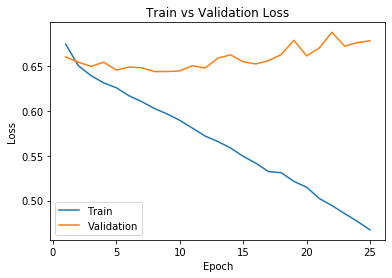

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.425375, Train loss: 0.6720080829802013 |Validation err: 0.406, Validation loss: 0.6588861905038357
Epoch 2: Train err: 0.385625, Train loss: 0.6488810966885279 |Validation err: 0.3895, Validation loss: 0.6526624895632267
Epoch 3: Train err: 0.369125, Train loss: 0.6373313050421457 |Validation err: 0.38, Validation loss: 0.6488607563078403
Epoch 4: Train err: 0.356625, Train loss: 0.6281884520772903 |Validation err: 0.385, Validation loss: 0.6558894775807858
Epoch 5: Train err: 0.35175, Train loss: 0.6228815960505653 |Validation err: 0.3875, Validation loss: 0.6444472298026085
Epoch 6: Train err: 0.338375, Train loss: 0.6132295737190853 |Validation err: 0.388, Validation loss: 0.6492169350385666
Epoch 7: Train err: 0.32975, Train loss: 0.6058863439257183 |Validation err: 0.383, Validation loss: 0.6477864570915699
Epoch 8: Train err: 0.319375, Train loss: 0.5958030905042376 |Validation err: 

In [5]:
# Answer: ANN model performed worser compared to CNN model as CNN model has a
# test error 0.3055, while ANN model has a test error 0.3535


import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim

torch.manual_seed(1) # set the random seed

# define a 2-layer artificial neural network
class Pigeon(nn.Module):
    def __init__(self):
        super(Pigeon, self).__init__()
        self.name = "Pigeon"
        self.layer1 = nn.Linear(3 * 32 * 32, 32)
        self.layer2 = nn.Linear(32, 1)
    def forward(self, img):
        flattened = img.view(-1, 3 * 32 * 32)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2 = activation2.squeeze(1)
        return activation2

pigeon = Pigeon()

def evaluate_pigeon(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss


def train_net_pigeon(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate_pigeon(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

train_net_pigeon(pigeon, batch_size=128, learning_rate=0.006, num_epochs=27)

model_path_pigeon = get_model_name("Pigeon", batch_size=128, learning_rate=0.005,
                                   epoch=24)
plot_training_curve(model_path_pigeon)

pigeon = Pigeon()
train_net_pigeon(pigeon, batch_size=128, learning_rate=0.006, num_epochs=27)
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=64)
criterion = nn.BCEWithLogitsLoss()
terror, tloss = evaluate(pigeon, test_loader, criterion)
print(("Test Error: {}, Test Loss: {}").format(
                   terror,
                   tloss))
